<a href="https://colab.research.google.com/github/mohandabdelhalim99/Medical-image-captionninng/blob/main/1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [5]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
import os
import cv2
from google.colab.patches import cv2_imshow
import re
from tqdm import tqdm 
from google.colab import drive
import random
import matplotlib.pyplot as plt




# Visualizing images

In [6]:
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [7]:
Reports_path='/content/gdrive/MyDrive/Reports/NLMCXR_reports.tgz (Unzipped Files)/ecgen-radiology'
Images_path='/content/gdrive/MyDrive/Image_captionning/NLMCXR_png.tgz (Unzipped Files)' 


In [8]:
print("number of images in dataset is {}".format(len(os.listdir(Images_path))))

number of images in dataset is 7470


In [9]:
random.choice(os.listdir(Images_path)) 

'CXR144_IM-0283-1001.png'

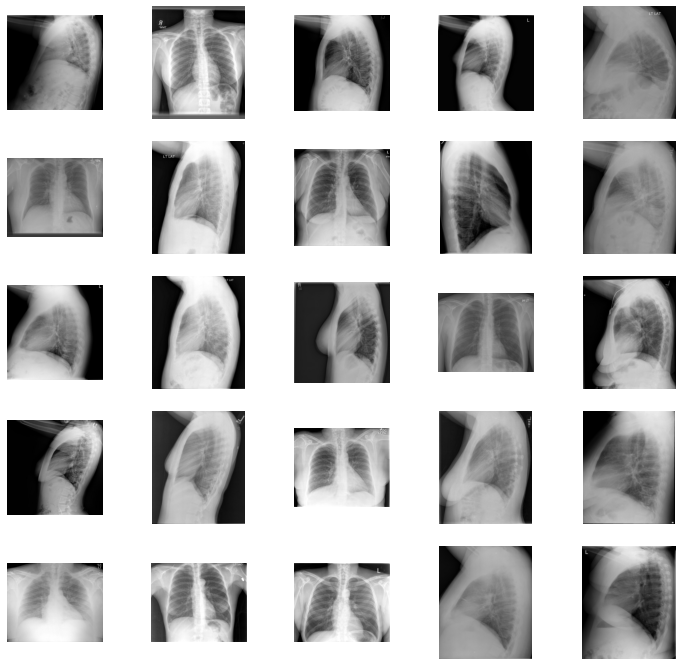

In [10]:

L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    rand_img=random.choice(os.listdir(Images_path)) 
    path=Images_path+'/'+rand_img
    img=cv2.imread(path)
    axes[i].imshow(img)
    axes[i].axis('off')
    

plt.subplots_adjust(wspace = 0.5)  

# Visualize Reports

In [11]:
print("number of reports in dataset is {}".format(len(os.listdir(Reports_path))))

number of reports in dataset is 3955


now we want to know max and min no of images in
dataset that is associated with one report

In [12]:
images_list=[]
for file in os.listdir(Reports_path):
  report_full_path=os.path.join(Reports_path,file)
  with open(report_full_path,'r')as f:
    data=f.read()
  regex= "<parentImage id=+"
  images_per_report=re.findall(regex,data)
  no_of_images=len(images_per_report)
  images_list.append(no_of_images)


In [13]:
print(data)

<?xml version="1.0" encoding="utf-8"?>
<eCitation>
   <meta type="rr"/>
   <uId id="CXR1868"/>
   <pmcId id="1868"/>
   <docSource>CXR</docSource>
   <IUXRId id="1868"/>
   <licenseType>open-access</licenseType>
   <licenseURL>http://creativecommons.org/licenses/by-nc-nd/4.0/</licenseURL>
   <ccLicense>byncnd</ccLicense>
   <articleURL/>
   <articleDate>2013-08-01</articleDate>
   <articleType>XR</articleType>
   <publisher>Indiana University</publisher>
   <title>Indiana University Chest X-ray Collection</title>
   <note>The data are drawn from multiple hospital systems.</note>
   <specialty>pulmonary diseases</specialty>
   <subset>CXR</subset>
   <MedlineCitation Owner="Indiana University" Status="supplied by publisher">
   
      <Article PubModel="Electronic">
      
         <Journal>
         
            <JournalIssue>
            
               <PubDate>
               
                  <Year>2013</Year>
               
                  <Month>08</Month>
               
   

Text(0, 0.5, 'count of reports')

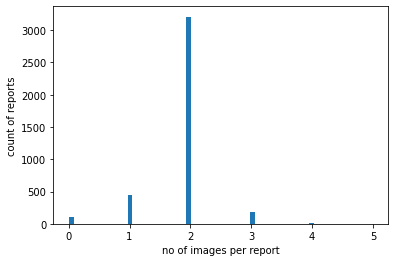

In [14]:
plt.hist(images_list,bins=int(np.sqrt(len(images_list))));
plt.xlabel('no of images per report')
plt.ylabel('count of reports')

-we will work with assumption that each report is associated with only 2 images as it's the highest frequency number.

-in each report we are searching for   :

1-impression 

2-finding

3-indication

4-comparsion


# Replace confusing contractions

In [15]:
def remove_contraction(phrase):
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


# Extract info and preprocess

In [35]:

def get_info(xml_data,info): 


  regex = r"\""  +info +r".*" 
  k = re.findall(regex,xml_data)[0] 

  regex = r"\>.*\<"
  k = re.findall(regex,k)[0] #removing info string and /AbstractText>'

  regex = r"\d." 
  k = re.sub(regex,"",k) #removing all values like "1." and "2." etc

  regex = r"X+"
  k = re.sub(regex,"",k) #removing words like XXXX

  regex = r" \."
  k = re.sub(regex,"",k) #removing singular fullstop ie " ."

  regex = r"[^.a-zA-Z]" 
  k = re.sub(regex," ",k) #removing all special characters except for full stop

  regex = r"\."
  k = re.sub(regex," .",k) #adding space before fullstop
  k = remove_contraction(k) #perform decontraction
  k = k.strip().lower() #strips the begining and end of the string of spaces and converts all into lowercase
  k = " ".join(k.split()) #removes unwanted spaces
  if k=="": #if the resulting sentence is an empty string return null value
    k = np.nan
  return k

In [36]:
get_info(data,'INDICATION')

'ovarian hyperstimulation syndrome rest for abnormality'

In [37]:
def get_final(data):
  try:
    comparison=get_info(data,'COMPARISON')
  except:
    comparison=np.nan

  try:
    indication=get_info(data,'INDICATION')
  except:
    indication=np.nan

  try:
    finding=get_info(data,'FINDING')
  except:
    finding=np.nan

  try:
    impression=get_info(data,'IMPRESSION')
  except:
    impression=np.nan

  return comparison,indication,finding,impression

In [38]:
get_final(data)

(nan,
 'ovarian hyperstimulation syndrome rest for abnormality',
 'heart size and pulmonary vascularity normal . there is a small right pleural effusion . there is infrahilar interstitial prominence which may represent bronchovascular crowding lung . small left pleural effusion . no pneumothorax .',
 'small bilateral pleural effusions and right infrahilar infiltrate versus bronchovascular crowding .')

# Create DataFrame

In [126]:
def create_df():
  imgg1=[]
  imgg2=[]
  comparisons=[]
  indications=[]
  findings=[]
  impressions=[]
  report=[]
  for file in tqdm(os.listdir(Reports_path)):
    report_path=os.path.join(Reports_path,file)
    with open(report_path,'r') as f:
      data=f.read()
    regex =r'parentImage id.*'
    k=re.findall(regex,data)
    if k == []:
      continue
    if len(k)==2:  ##only 2 images
        regex=r"\".*\""
        img1=re.findall(regex,k[0])[0]
        img2=re.findall(regex,k[1])[0]
        img1=re.sub('\"',"",img1)
        img2=re.sub('\"',"",img2)
        img1=img1.strip()+'.png'
        img2=img2.strip()+'.png'
        imgg1.append(img1)
        imgg2.append(img2)
        comparison,indication,finding,impression=get_final(data)
        comparisons.append(comparison)
        indications.append(indication)
        findings.append(finding)
        impressions.append(impression)
        report.append(file)

    elif len(k)<2:
        regex='\".*\"'
        img1=re.findall(regex,k[0])[0]
        img2=np.nan
        img1=re.sub('\"',"",img1)
        img1=img1.strip()+'.png'
        imgg1.append(img1)
        imgg2.append(img2)
        comparison,indication,finding,impression=get_final(data)
        comparisons.append(comparison)
        indications.append(indication)
        findings.append(finding)
        impressions.append(impression)
        report.append(file)

    else :    ##take first two and neglect the rest(different approach)

        regex='\".*\"'
        img1=re.findall(regex,k[0])[0]
        img2=re.findall(regex,k[1])[0]
        img1=re.sub('\"',"",img1)
        img2=re.sub('\"',"",img2)
        img1=img1.strip()+'.png'
        img2=img2.strip()+'.png'
        imgg1.append(img1)
        imgg2.append(img2)
        comparison,indication,finding,impression=get_final(data)
        comparisons.append(comparison)
        indications.append(indication)
        findings.append(finding)
        impressions.append(impression)
        report.append(file)



  df = pd.DataFrame({"image_1":imgg1,"image_2":imgg2,"comparison":comparisons,"indication":indications,"findings":findings,"impression":impressions,"xml file name":report})
  return df




In [127]:
create_df()

100%|██████████| 3955/3955 [00:11<00:00, 339.67it/s]


,image_1,image_2,comparison,indication,findings,impression,xml file name
0,CXR3692_IM-1843-1001.png,CXR3692_IM-1843-2001.png,NaN,chest pain,stable cardiomediastinal silhouette . pulmonar...,no acute cardiopulmonary abnormality .,3692.xml
1,CXR3693_IM-1844-1001.png,CXR3693_IM-1844-1002.png,ct of the chest dated,year old woman .,the lungs are clear bilaterally . specifically...,no acute cardiopulmonary abnormality .,3693.xml
2,CXR3694_IM-1845-1001.png,CXR3694_IM-1845-2001.png,portable chest hours,year old female chest tube removal .,interval removal of left sided chest tube . sm...,no acute cardiopulmonary abnormality .,3694.xml
3,CXR3695_IM-1845-1001.png,CXR3695_IM-1845-2001.png,NaN,shortness of breath,the cardiac silhouette size is at the upper li...,mild central vascular prominence congestion . ...,3695.xml
4,CXR3697_IM-1846-1001.png,CXR3697_IM-1846-2001.png,NaN,year old male with,the cardiomediastinal silhouette is stable in ...,no acute cardiopulmonary findings . extensive ...,3697.xml
...,...,...,...,...,...,...,...
3846,CXR1864_IM-0558-1001.png,CXR1864_IM-0558-3001.png,none,year old male pain,heart size borderline enlarged . no focal alve...,borderline heart size no acute pulmonary findings,1864.xml
3847,CXR1865_IM-0558-1001.png,CXR1865_IM-0558-2001.png,none,syncope,heart size is normal . the lungs are clear . t...,no acute abnormality .,1865.xml
3848,CXR1866_IM-0559-1001.png,CXR1866_IM-0559-2001.png,NaN,NaN,the heart and lungs have in the interval . bot...,no active disease .,1866.xml
3849,CXR1867_IM-0560-1001.png,CXR1867_IM-0560-4004.png,outside chest radiograph earlier,fractured femur preop,cardiomegaly and tortuous calcified thoracic a...,mild cardiomegaly without pulmonary edema . mi...,1867.xml


In [128]:
Dataframe=create_df()

100%|██████████| 3955/3955 [00:06<00:00, 587.35it/s]


# Check for nulls

In [129]:
Dataframe.isnull().sum()*100/Dataframe.shape[0]

image_1           0.000000
image_2          11.581407
comparison       33.186185
indication        6.361984
findings         13.347183
impression        0.804986
xml file name     0.000000
dtype: float64

In [130]:
Dataframe.shape[0]

3851

**Drop instances where imprression is null**

In [131]:
Dataframe.drop(Dataframe[Dataframe['impression'].isnull()].index,inplace=True)
Dataframe.reset_index(drop=True)

,image_1,image_2,comparison,indication,findings,impression,xml file name
0,CXR3692_IM-1843-1001.png,CXR3692_IM-1843-2001.png,NaN,chest pain,stable cardiomediastinal silhouette . pulmonar...,no acute cardiopulmonary abnormality .,3692.xml
1,CXR3693_IM-1844-1001.png,CXR3693_IM-1844-1002.png,ct of the chest dated,year old woman .,the lungs are clear bilaterally . specifically...,no acute cardiopulmonary abnormality .,3693.xml
2,CXR3694_IM-1845-1001.png,CXR3694_IM-1845-2001.png,portable chest hours,year old female chest tube removal .,interval removal of left sided chest tube . sm...,no acute cardiopulmonary abnormality .,3694.xml
3,CXR3695_IM-1845-1001.png,CXR3695_IM-1845-2001.png,NaN,shortness of breath,the cardiac silhouette size is at the upper li...,mild central vascular prominence congestion . ...,3695.xml
4,CXR3697_IM-1846-1001.png,CXR3697_IM-1846-2001.png,NaN,year old male with,the cardiomediastinal silhouette is stable in ...,no acute cardiopulmonary findings . extensive ...,3697.xml
...,...,...,...,...,...,...,...
3815,CXR1864_IM-0558-1001.png,CXR1864_IM-0558-3001.png,none,year old male pain,heart size borderline enlarged . no focal alve...,borderline heart size no acute pulmonary findings,1864.xml
3816,CXR1865_IM-0558-1001.png,CXR1865_IM-0558-2001.png,none,syncope,heart size is normal . the lungs are clear . t...,no acute abnormality .,1865.xml
3817,CXR1866_IM-0559-1001.png,CXR1866_IM-0559-2001.png,NaN,NaN,the heart and lungs have in the interval . bot...,no active disease .,1866.xml
3818,CXR1867_IM-0560-1001.png,CXR1867_IM-0560-4004.png,outside chest radiograph earlier,fractured femur preop,cardiomegaly and tortuous calcified thoracic a...,mild cardiomegaly without pulmonary edema . mi...,1867.xml


In [132]:
Dataframe.shape[0]

3820

**Replace missing image_2 with image_1**

In [133]:
Dataframe.loc[Dataframe['image_2'].isnull(),'image_2']=Dataframe[Dataframe['image_2'].isnull()]['image_1'].values

In [134]:
Dataframe.head()

,image_1,image_2,comparison,indication,findings,impression,xml file name
0,CXR3692_IM-1843-1001.png,CXR3692_IM-1843-2001.png,NaN,chest pain,stable cardiomediastinal silhouette . pulmonar...,no acute cardiopulmonary abnormality .,3692.xml
1,CXR3693_IM-1844-1001.png,CXR3693_IM-1844-1002.png,ct of the chest dated,year old woman .,the lungs are clear bilaterally . specifically...,no acute cardiopulmonary abnormality .,3693.xml
2,CXR3694_IM-1845-1001.png,CXR3694_IM-1845-2001.png,portable chest hours,year old female chest tube removal .,interval removal of left sided chest tube . sm...,no acute cardiopulmonary abnormality .,3694.xml
3,CXR3695_IM-1845-1001.png,CXR3695_IM-1845-2001.png,NaN,shortness of breath,the cardiac silhouette size is at the upper li...,mild central vascular prominence congestion . ...,3695.xml
4,CXR3697_IM-1846-1001.png,CXR3697_IM-1846-2001.png,NaN,year old male with,the cardiomediastinal silhouette is stable in ...,no acute cardiopulmonary findings . extensive ...,3697.xml


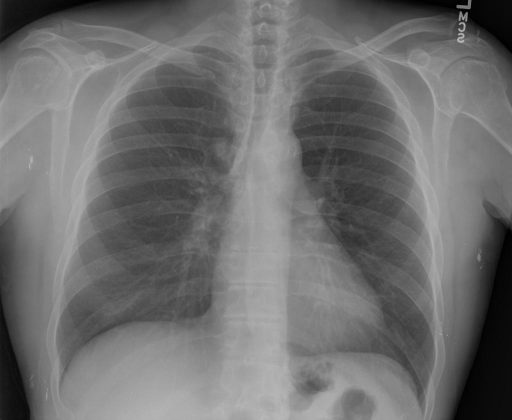


 Comparison:  nan

 Indication:  chest pain

 Findings:  stable cardiomediastinal silhouette . pulmonary vascularity is within normal limits . lungs are expanded and clear airspace disease . negative for pneumothorax or pleural effusion . limited evaluation reveals the to be grossly intact .

 Impression:  no acute cardiopulmonary abnormality . 

 ****************************************************************************************************************************************************** 




In [137]:
sample=Dataframe['image_1'].values[0]
path=os.path.join(Images_path,sample)
img=cv2.imread(path)

cv2_imshow(img)

print("\n","Comparison: ",Dataframe['comparison'].values[0])
print("\n","Indication: ",Dataframe['indication'].values[0])
print("\n","Findings: ",Dataframe['findings'].values[0])
print("\n","Impression: ",Dataframe['impression'].values[0],"\n\n","*"*150,"\n\n")

In [138]:
Dataframe.to_csv("Data.csv")